In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/criteo-dataset/dac/test.txt
/kaggle/input/criteo-dataset/dac/readme.txt
/kaggle/input/criteo-dataset/dac/train.txt


In [2]:
import seaborn as sns;
import matplotlib.pyplot as plt
import scipy

from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

import lightgbm as lgbm

In [3]:
col_names_train = ['Label'] + \
["I"+str(i) for i in range(1, 14)] + \
['C'+str(i) for i in range(1,27)]

#col_names_test = col_names_train[1:]

df_train = pd.read_csv('/kaggle/input/criteo-dataset/dac/train.txt', 
                       sep='\t', names=col_names_train,
                       chunksize=100000) # ten chunks: first 1,000,000

# df_test = pd.read_csv('/kaggle/input/criteo-dataset/dac/test.txt', 
#                       sep='\t', names=col_names_test,
#                       chunksize=100000)

# don't re-run, getting without replacement
df_train_100 = df_train.get_chunk(1000000)
df_test_25 = df_train.get_chunk(250000)

# Using the first one million records for analysis
# use the next 250,000 as testing data

In [4]:
# for simplicity of model fitting, no cross-validation process
# directly train on df_train_100 and test for performance on df_test_25 

df_train_100 = df_train_100.convert_dtypes()
df_test_25 = df_test_25.convert_dtypes()

## Notes
- Using the first one million records for analysis
- Using the next 250,000 as testing data
- for simplicity of model fitting, no cross-validation process
- directly train on df_train_100 and test for performance on df_test_25

## 有大量缺失的特征和标签间的相关性调查

- above 70% missing: I12, C22

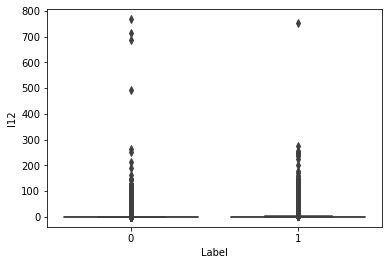

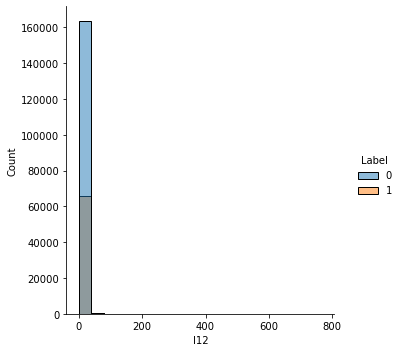

In [5]:
# I12 0.770057
p1 = sns.boxplot(x="Label", y="I12", data=df_train_100)
p2 = sns.displot(df_train_100, x="I12", hue="Label")

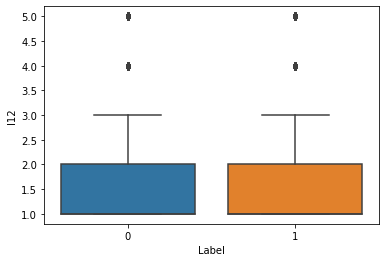

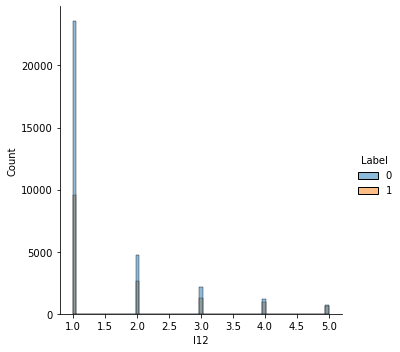

In [6]:
I12_temp = df_train_100[df_train_100.I12.between(1,5)]
p1 = sns.boxplot(x="Label", y="I12", data=I12_temp)
p2 = sns.displot(I12_temp, x="I12", hue="Label")

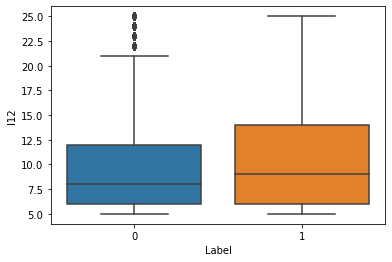

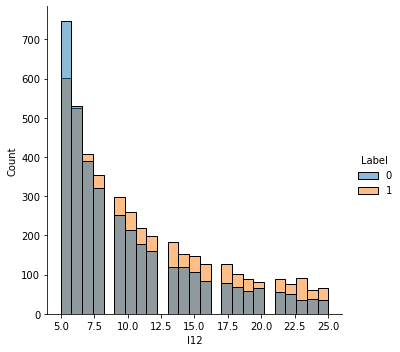

In [7]:
I12_temp = df_train_100[df_train_100.I12.between(5,25)]
p1 = sns.boxplot(x="Label", y="I12", data=I12_temp)
p2 = sns.displot(I12_temp, x="I12", hue="Label")

- I12与Label间无明显相关性（各个值上都出现两种标签），77%缺少 -> 可考虑舍弃该特征
- 或对数值类特征分箱/离散化

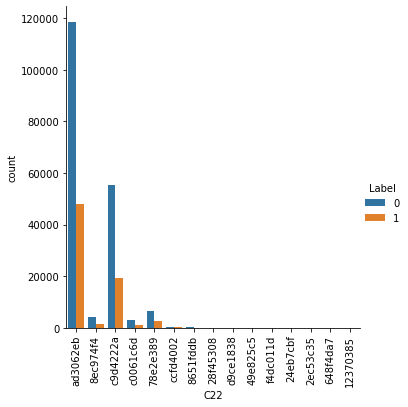

In [8]:
# C22      0.738959
p1 = sns.catplot(x='C22', hue='Label', kind='count', data=df_train_100)
plt.xticks(rotation=90)
plt.show()

## 特征工程 - GBDT
- basing on 3idiots-preA
- https://github.com/ycjuan/kaggle-2014-criteo
- https://www.kaggle.com/c/criteo-display-ad-challenge/discussion/10555
- replace all numerical missing values with -10; one-hot encoding with selection (only include dense variables)
`target_cat_feats = ['C9-a73ee510', 'C22-', 'C17-e5ba7672', 'C26-', 'C23-32c7478e', 'C6-7e0ccccf', 'C14-b28479f6', 'C19-21ddcdc9', 'C14-07d13a8f', 'C10-3b08e48b', 'C6-fbad5c96', 'C23-3a171ecb', 'C20-b1252a9d', 'C20-5840adea', 'C6-fe6b92e5', 'C20-a458ea53', 'C14-1adce6ef', 'C25-001f3601', 'C22-ad3062eb', 'C17-07c540c4', 'C6-', 'C23-423fab69', 'C17-d4bb7bd8', 'C2-38a947a1', 'C25-e8b83407', 'C9-7cc72ec2']`
- 特征构建逻辑: 有缺失的数值型特征都只含非负值（除了I2，最小值-2但无缺失），-10是给NA赋了一个特殊值，并且无缺失项有负值，所以给NA赋负值较为合理（**可用其他值，范围外不影响score**）；对所有类别型特征做one-hot后只保留稠密（在原完整训练集中出现超过四百万次）的特征，因为传统gbdt不适合过分稀疏的特征矩阵（prohibitively expensive computation & memory problem），原始one-hot之后的特征需做筛选（**可根据此训练集尝试其他筛选**）

### 3-idiots methods

In [9]:
def pre1_gbdt(df_train, df_test):
    '''
    Function for preprocessing dataframes for gbdt model with methods in 
    Team 3idiots' solution.
    '''
    
    my_dict = dict.fromkeys(col_names_train[1:14], -10)
    my_dict.update(dict.fromkeys(col_names_train[14:], 'NA'))

    df_train = df_train.fillna(my_dict) # inplace=True will change global var
    df_test = df_test.fillna(my_dict)
    
#     df1 = pd.get_dummies(df_train_100, columns=df_train_100.columns[14:],
#                          prefix=col, prefix_sep='-',
#                          dummy_na=True, sparse=True)
    
    y_train = df_train.Label.values.astype('int')
    y_test = df_test.Label.values.astype('int')
    
    ct = ColumnTransformer(transformers=[('encoder',
                                      OneHotEncoder(handle_unknown='ignore'), 
                                      col_names_train[14:])],
                       remainder='passthrough')
    X_train = ct.fit_transform(df_train.iloc[:, 1:]) # sparse matrix
    X_test = ct.transform(df_test.iloc[:, 1:]) # sparse matrix
    
    target_feats = ['encoder__x8_a73ee510', 'encoder__x21_NA',
                    'encoder__x16_e5ba7672', 'encoder__x25_NA', 
                    'encoder__x22_32c7478e', 'encoder__x5_7e0ccccf',
                    'encoder__x13_b28479f6', 'encoder__x18_21ddcdc9',
                    'encoder__x13_07d13a8f', 'encoder__x9_3b08e48b',
                    'encoder__x5_fbad5c96', 'encoder__x22_3a171ecb',
                    'encoder__x19_b1252a9d', 'encoder__x19_5840adea',
                    'encoder__x5_fe6b92e5', 'encoder__x19_a458ea53', 
                    'encoder__x13_1adce6ef', 'encoder__x24_001f3601',
                    'encoder__x21_ad3062eb', 'encoder__x16_07c540c4',
                    'encoder__x5_NA', 'encoder__x22_423fab69', 
                    'encoder__x16_d4bb7bd8', 'encoder__x1_38a947a1',
                    'encoder__x24_e8b83407', 'encoder__x8_7cc72ec2'] \
    + ["I"+str(i) for i in range(1, 14)]
    index_selected = [i for i, x in enumerate(ct.get_feature_names())\
                      if x in target_feats]
    
    X_train = X_train[:, index_selected]
    X_test = X_test[:, index_selected]
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = pre1_gbdt(df_train_100, df_test_25)

In [10]:
# GBDT model only, pre1_gbdt
grd = GradientBoostingClassifier() # with default setting
grd.fit(X_train, y_train)

y_pred_train_grd = grd.predict_proba(X_train)[:, 1] # prob of y=1
y_pred_test_grd = grd.predict_proba(X_test)[:, 1] # prob of y=1
score_train = log_loss(y_train, y_pred_train_grd)
score_test = log_loss(y_test, y_pred_test_grd)
np.round(score_train, 4), np.round(score_test, 4)

(0.4982, 0.4968)

training, testing : (0.4982, 0.4968) - 13 + 26 variables

### modification on 3-idiots

In [11]:
def pre2_gbdt(df_train, df_test):
    '''
    Function for preprocessing dataframes for gbdt model with modification on
    methods in Team 3idiots' solution:
    - dropping I12;
    - one-hot encodded features with appearance more than ..%.
    '''
    
    my_dict = dict.fromkeys(col_names_train[1:14], -10)
    my_dict.update(dict.fromkeys(col_names_train[14:], 'NA'))

    df_train = df_train.fillna(my_dict) # inplace=True will change global var
    df_test = df_test.fillna(my_dict)
    
    y_train = df_train.Label.values.astype('int')
    y_test = df_test.Label.values.astype('int')
    
    ct = ColumnTransformer(transformers=[('encoder',
                                      OneHotEncoder(handle_unknown='ignore'), 
                                      col_names_train[14:])],
                       remainder='passthrough')
    X_train = ct.fit_transform(df_train.iloc[:, 1:]) # sparse matrix
    X_test = ct.transform(df_test.iloc[:, 1:]) # sparse matrix
    
    # select one-hot encodded features with appearance more than ..%
    selected_cat = np.asarray(X_train.sum(axis=0)[:,:-13] > 500000).reshape(-1)
    # exclude I12
    target_feats = [i for (i, v) in zip(ct.get_feature_names(), selected_cat) if v] \
    + ["I"+str(i) for i in range(1, 12)] + ['I13']
    index_selected = [i for i, x in enumerate(ct.get_feature_names())\
                      if x in target_feats]
    
    X_train = X_train[:, index_selected]
    X_test = X_test[:, index_selected]
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = pre2_gbdt(df_train_100, df_test_25)

In [12]:
# GBDT model only, pre2_gbdt
grd = GradientBoostingClassifier() # with default setting
grd.fit(X_train, y_train)

y_pred_train_grd = grd.predict_proba(X_train)[:, 1] # prob of y=1
y_pred_test_grd = grd.predict_proba(X_test)[:, 1] # prob of y=1
score_train = log_loss(y_train, y_pred_train_grd)
score_test = log_loss(y_test, y_pred_test_grd)
np.round(score_train, 4), np.round(score_test, 4)

(0.5054, 0.5044)

- training, testing : (0.4987, 0.4976) - dropping I12 (12 + 26 variables)
- training, testing : (0.5038, 0.5027) - dropping I12 & above 40% dummies only (12 + 9 variables - `['encoder__x0_05db9164',
 'encoder__x4_25c83c98',
 'encoder__x7_0b153874',
 'encoder__x8_a73ee510',
 'encoder__x16_e5ba7672',
 'encoder__x18_NA',
 'encoder__x19_NA',
 'encoder__x21_NA',
 'encoder__x24_NA',
 'encoder__x25_NA']`)
- training, testing : (0.5054, 0.5044) - dropping I12 & above 50% dummies only (12 + 5 variables - `['encoder__x0_05db9164',
 'encoder__x4_25c83c98',
 'encoder__x7_0b153874',
 'encoder__x8_a73ee510',
 'encoder__x21_NA']`)

### 数值型特征离散化

- the value in replace with na may matter here

In [13]:
def pre3_gbdt(df_train, df_test):
    '''
    Function for preprocessing dataframes for gbdt model with modification on
    methods in Team 3idiots' solution:
    - quantile discretization & one-hot on numerical features;
    - one-hot encodded features with appearance more than 50%.
    '''
    
    my_dict = dict.fromkeys(col_names_train[1:14], -10)
    my_dict.update(dict.fromkeys(col_names_train[14:], 'NA'))

    df_train = df_train.fillna(my_dict) # inplace=True will change global var
    df_test = df_test.fillna(my_dict)
    
    y_train = df_train.Label.values.astype('int')
    y_test = df_test.Label.values.astype('int')
    
    # transformers: discretization and one-hot encoding
    numeric_features = col_names_train[1:14]
    numeric_transformer = KBinsDiscretizer(n_bins=10, encode='onehot',
                                           strategy='quantile')

    categorical_features = col_names_train[14:]
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    ct = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    X_train = ct.fit_transform(df_train.iloc[:, 1:]) # sparse matrix
    X_test = ct.transform(df_test.iloc[:, 1:]) # sparse matrix
    
    # select one-hot encodded features with appearance more than 50%
    selected_cat = np.asarray(X_train.sum(axis=0) > 500000).reshape(-1)
    
    X_train = X_train[:, selected_cat]
    X_test = X_test[:, selected_cat]
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = pre3_gbdt(df_train_100, df_test_25)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.

In [14]:
# GBDT model only, pre3_gbdt
grd = GradientBoostingClassifier() # with default setting
grd.fit(X_train, y_train)

y_pred_train_grd = grd.predict_proba(X_train)[:, 1] # prob of y=1
y_pred_test_grd = grd.predict_proba(X_test)[:, 1] # prob of y=1
score_train = log_loss(y_train, y_pred_train_grd)
score_test = log_loss(y_test, y_pred_test_grd)
np.round(score_train, 4), np.round(score_test, 4)

(0.5609, 0.5565)

- training, testing : (0.5506, 0.5468) - uniform discretization (-10 for NA, n_bins=10) + appearance more than 50% (17 variables)
- training, testing : (0.541, 0.538) - kmeans discretization (-10 for NA, n_bins=5) + appearance more than 50% (17 variables)
- training, testing : (0.5609, 0.5565) - quantile discretization (-1/-10/-100 for NA, n_bins=10/5) + appearance more than 50% (6 variables)

## 特征工程：GBDT+LR


- 人工特征 + LR: same/similar results as gbdt (ref: https://datascience.stackexchange.com/questions/18081/gradient-boosting-vs-logistic-regression-for-boolean-features)
    - kmeans: (0.5428, 0.5397)
    - quantile: (0.5609, 0.5565)
    - uniform: (0.5506, 0.5469)

In [15]:
# using pre3_gbdt preprocessed features directly in LR
#X_train, X_test, y_train, y_test = pre3_gbdt(df_train_100, df_test_25)

lr = LogisticRegression(random_state=0, solver='sag', max_iter=1000) 
# stochastic average gradient, l2 penalty
lr.fit(X_train, y_train)

y_pred_train_lr = lr.predict_proba(X_train)[:, 1] # prob of y=1
y_pred_test_lr = lr.predict_proba(X_test)[:, 1] # prob of y=1
score_train = log_loss(y_train, y_pred_train_lr)
score_test = log_loss(y_test, y_pred_test_lr)
np.round(score_train, 4), np.round(score_test, 4)

(0.5609, 0.5565)

In [16]:
def pre3_gbdt_temp(df_train, df_test):
    '''
    Function for preprocessing dataframes for gbdt model with modification on
    methods in Team 3idiots' solution:
    - kmeans discretization & one-hot on numerical features;
    - one-hot encodded features with appearance more than 50%.
    '''
    
    my_dict = dict.fromkeys(col_names_train[1:14], -10)
    my_dict.update(dict.fromkeys(col_names_train[14:], 'NA'))

    df_train = df_train.fillna(my_dict) # inplace=True will change global var
    df_test = df_test.fillna(my_dict)
    
    y_train = df_train.Label.values.astype('int')
    y_test = df_test.Label.values.astype('int')
    
    # transformers: discretization and one-hot encoding
    numeric_features = col_names_train[1:14]
    numeric_transformer = KBinsDiscretizer(n_bins=5, encode='onehot',
                                           strategy='kmeans')

    categorical_features = col_names_train[14:]
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    ct = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    X_train = ct.fit_transform(df_train.iloc[:, 1:]) # sparse matrix
    X_test = ct.transform(df_test.iloc[:, 1:]) # sparse matrix
    
    # select one-hot encodded features with appearance more than 50%
    selected_cat = np.asarray(X_train.sum(axis=0) > 500000).reshape(-1)
    
    X_train = X_train[:, selected_cat]
    X_test = X_test[:, selected_cat]
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = pre3_gbdt_temp(df_train_100, df_test_25)

In [17]:
# using pre3_gbdt_temp preprocessed features in LR
lr = LogisticRegression(random_state=0, solver='sag', max_iter=1000) # stochastic average gradient
lr.fit(X_train, y_train)

y_pred_train_lr = lr.predict_proba(X_train)[:, 1] # prob of y=1
y_pred_test_lr = lr.predict_proba(X_test)[:, 1] # prob of y=1
score_train = log_loss(y_train, y_pred_train_lr)
score_test = log_loss(y_test, y_pred_test_lr)
np.round(score_train, 4), np.round(score_test, 4)

(0.5428, 0.5397)

- GBDT特征 + LR: taking the index of the prediction leaf node for every tree as the sparse input for logistic regression (ref: https://towardsdatascience.com/next-better-player-gbdt-lr-for-binary-classification-f8dc6f32628e) (ref: https://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#example-ensemble-plot-feature-transformation-py)

    1. 延用之前的GBDT框架（pre3_gbdt, 6 variables) -> 800 (100 tree, depth 3) leaf index feature into LR(random_state=0, solver='sag', max_iter=1000, penalty='l2') -> (0.5609, 0.5565)， 和之前一样
    2. 之前的GBDT框架+其他筛选条件（pre1_lr) (LR: random_state=0, solver='saga', penalty='l1', max_iter=1000):
        - 10% : 103 variables, GBDT score (0.504, 0.5019) -> LR score (0.4979, 0.4967)
        - 30% : 19 variables, GBDT score (0.5392, 0.5358) -> LR score (0.5386, 0.5355)

In [18]:
def pre1_lr(df_train, df_test):
    '''
    Function for preprocessing dataframes to get GBDT features for lr model.
    - quantile discretization & one-hot on numerical features;
    - one-hot encodded features with appearance more than ..%.
    '''
    
    my_dict = dict.fromkeys(col_names_train[1:14], -10)
    my_dict.update(dict.fromkeys(col_names_train[14:], 'NA'))

    df_train = df_train.fillna(my_dict) # inplace=True will change global var
    df_test = df_test.fillna(my_dict)
    
    y_train = df_train.Label.values.astype('int')
    y_test = df_test.Label.values.astype('int')
    
    # transformers: discretization and one-hot encoding
    numeric_features = col_names_train[1:14]
    numeric_transformer = KBinsDiscretizer(n_bins=10, encode='onehot',
                                           strategy='quantile')

    categorical_features = col_names_train[14:]
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    ct = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    X_train = ct.fit_transform(df_train.iloc[:, 1:]) # sparse matrix
    X_test = ct.transform(df_test.iloc[:, 1:]) # sparse matrix
    
    # select one-hot encodded features with appearance more than 30%
    selected_cat = np.asarray(X_train.sum(axis=0) > 300000).reshape(-1)
    
    X_train = X_train[:, selected_cat]
    X_test = X_test[:, selected_cat]
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = pre1_lr(df_train_100, df_test_25)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.

In [19]:
# 中间检查，GBDT模型效果
grd = GradientBoostingClassifier() # n_estimators=100, max_depth=3
grd.fit(X_train, y_train)

y_pred_train_grd = grd.predict_proba(X_train)[:, 1] # prob of y=1
y_pred_test_grd = grd.predict_proba(X_test)[:, 1] # prob of y=1
score_train = log_loss(y_train, y_pred_train_grd)
score_test = log_loss(y_test, y_pred_test_grd)
np.round(score_train, 4), np.round(score_test, 4)

(0.5392, 0.5358)

In [20]:
# GBDT特征
#grd = GradientBoostingClassifier() # n_estimators=100, max_depth=3
grd_enc = OneHotEncoder()
#grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0]) # OHE on indexes
X_train_part2 = grd_enc.transform(grd.apply(X_train)[:, :, 0])
X_test_part2 = grd_enc.transform(grd.apply(X_test)[:, :, 0])

In [21]:
# # LR
# grd_lm = LogisticRegression(random_state=0, solver='saga', 
#                             penalty='l1', max_iter=1000)
# # feed into LR
# grd_lm.fit(X_train_part2, y_train)

# y_pred_train_grd_lm = grd_lm.predict_proba(X_train_part2)[:, 1]
# y_pred_test_grd_lm = grd_lm.predict_proba(X_test_part2)[:, 1]

# score_train = log_loss(y_train, y_pred_train_grd_lm)
# score_test = log_loss(y_test, y_pred_test_grd_lm)
# np.round(score_train, 4), np.round(score_test, 4)

- 人工特征 + GBDT特征 + LR
    - pre1_lr: 
        - 19+800 vars
        - `(random_state=0, solver='saga', penalty='l1', max_iter=1000)`
        - `(random_state=0, solver='saga', penalty='l1', max_iter=2000)`
        - didn't converge in 1000/2000, (0.5386, 0.5355)
    - pre3_gbdt: 
        - 6+800 vars 
        - `(random_state=0, solver='saga', penalty='l1', max_iter=1000)`
        - `(random_state=0, solver='sag', penalty='l2', max_iter=1000)`
        - (0.5609, 0.5565)

In [22]:
# 人工特征, continuing from `pre1_lr`
# X_train, X_test, y_train, y_test = pre1_lr(df_train_100, df_test_25)
# select one-hot encodded features with appearance more than 30%

# GBDT特征: X_train_part2, X_test_part2

# combined
X_train_new = scipy.sparse.hstack((X_train, X_train_part2))
X_test_new = scipy.sparse.hstack((X_test, X_test_part2))

In [23]:
# feed into LR
grd_lm = LogisticRegression(random_state=0, solver='saga', 
                            penalty='l1', max_iter=2000)
grd_lm.fit(X_train_new, y_train)

y_pred_train_grd_lm = grd_lm.predict_proba(X_train_new)[:, 1]
y_pred_test_grd_lm = grd_lm.predict_proba(X_test_new)[:, 1]

score_train = log_loss(y_train, y_pred_train_grd_lm)
score_test = log_loss(y_test, y_pred_test_grd_lm)
np.round(score_train, 4), np.round(score_test, 4)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


(0.5386, 0.5355)

In [24]:
# 人工特征, continuing from `pre3_gbdt`
# select one-hot encodded features with appearance more than 50%
X_train, X_test, y_train, y_test = pre3_gbdt(df_train_100, df_test_25)

# GBDT特征: X_train_part2, X_test_part2
grd = GradientBoostingClassifier() # n_estimators=100, max_depth=3
grd_enc = OneHotEncoder()
grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0]) # ohe on indexes
X_train_part2 = grd_enc.transform(grd.apply(X_train)[:, :, 0])
X_test_part2 = grd_enc.transform(grd.apply(X_test)[:, :, 0])

# combined
X_train_new = scipy.sparse.hstack((X_train, X_train_part2))
X_test_new = scipy.sparse.hstack((X_test, X_test_part2))

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.

In [25]:
# feed into LR
grd_lm = LogisticRegression(random_state=0, solver='sag', 
                            penalty='l2', max_iter=1000)
grd_lm.fit(X_train_new, y_train)

y_pred_train_grd_lm = grd_lm.predict_proba(X_train_new)[:, 1]
y_pred_test_grd_lm = grd_lm.predict_proba(X_test_new)[:, 1]

score_train = log_loss(y_train, y_pred_train_grd_lm)
score_test = log_loss(y_test, y_pred_test_grd_lm)
np.round(score_train, 4), np.round(score_test, 4)

(0.5609, 0.5565)